In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Load the data
df =pd.read_excel(r'Data.xlsx')

In [3]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
df.shape

(10683, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [231]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
#We have only two missing values so I drop them
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64



# Pre Prossecing

In [8]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

We need to fix the columns that represent time as DateTime from object

In [9]:
#convert object to datetime
def change_into_datetime(col):
    df[col]=pd.to_datetime(df[col])

In [10]:
#convert the datetime columns
for feature in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
    change_into_datetime(feature)

In [11]:
df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [12]:
#break the date of journey column in three new colums: day,month and year
df['journey_day']=df['Date_of_Journey'].dt.day
df['journey_month']=df['Date_of_Journey'].dt.month
df['journey_year']=df['Date_of_Journey'].dt.year

In [13]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-10-14 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-10-14 05:50:00,2022-10-14 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-10-14 09:25:00,2022-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-10-14 18:05:00,2022-10-14 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-10-14 16:50:00,2022-10-14 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019


In [14]:
df.drop('Date_of_Journey',axis=1,inplace=True)

In [15]:
df['journey_year'].unique()

array([2019], dtype=int64)

in journey_year he has only one value so this column doesn't provide us with any information so I will drop it!

In [16]:
df.drop('journey_year',axis=1,inplace=True)

# Feature Engineering

The dep_time as we can observe has the time when the flight departure so we can create 2 new columns: one for the hour and one for the minutes

In [17]:
#this function creates the new columns and then drops the starting column
def extract_hour_min(df,col):
    df[col+'_hour']=df[col].dt.hour
    df[col+'_minute']=df[col].dt.minute
    df.drop(col,axis=1,inplace=True)
    return df.head()

In [18]:
extract_hour_min(df,'Dep_Time')

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-10-14 13:15:00,7h 25m,2 stops,No info,7662,5,1,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2022-06-10 04:25:00,19h,2 stops,No info,13882,6,9,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2022-10-14 23:30:00,5h 25m,1 stop,No info,6218,5,12,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2022-10-14 21:35:00,4h 45m,1 stop,No info,13302,3,1,16,50


In [19]:
# lets do the same for the arrival time
extract_hour_min(df,'Arrival_Time')

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


Now lets take the column duration and create 3 new columns one for duration hours and one for duration minutes and one for the total duration of the flight in minutes

In [20]:
def preprocess_duration(x):
    if 'h' not in x:
        x='0h '+x
    elif 'm' not in x:
        x=x+' 0m'
    return x
    

In [21]:
df['Duration']=df['Duration'].apply(preprocess_duration)

In [22]:
df['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

In [23]:
df['Duration_hours']=df['Duration'].apply(lambda x:int(x.split(' ')[0][0:-1]))
df['Duration_mins']=df['Duration'].apply(lambda x:int(x.split(' ')[1][0:-1]))

In [24]:
#the total duration of the flight in minutes
df['Duration_total_mins']=df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [25]:
#drop the duration column
df.drop('Duration',axis=1,inplace=True)

In [26]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Duration_total_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45,285


# EDA

## What part of the day has the most departures?

In [27]:

# Converting the flight Dep_Time into proper time i.e. mid_night, morning, afternoon and evening.

def flight_dep_time(x):
    '''
    This function takes the flight Departure time 
    and convert into appropriate format.
    '''
    if ( x> 4) and (x<=8 ):
        return 'Early mrng'
    
    elif ( x>8 ) and (x<=12 ):
        return 'Morning'
    
    elif ( x>12 ) and (x<=16 ):
        return 'Noon'
    
    elif ( x>16 ) and (x<=20 ):
        return 'Evening'
    
    elif ( x>20 ) and (x<=24 ):
        return 'Night'
    else:
        return 'Late night'

<AxesSubplot:>

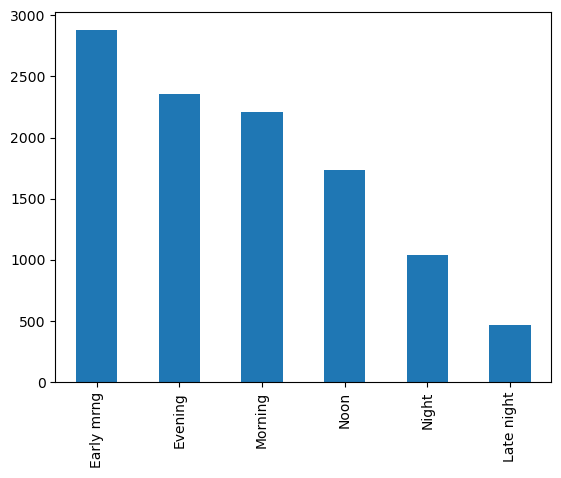

In [28]:
#apply the above function and visualize the result with a bar plot
df['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind='bar')

**Conclusion** From the graph we can see that the busiest hours are between 4 - 8 in the morning or 20- 24 in the evening

## which city has the maximum final destination of flights?

In [29]:
df['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

<AxesSubplot:>

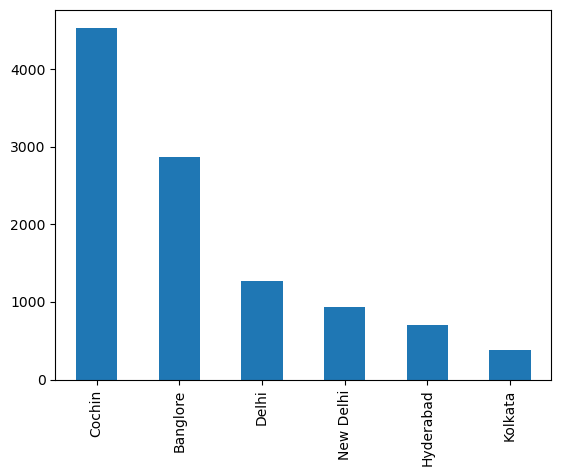

In [30]:
df['Destination'].value_counts().plot(kind='bar')

**Conclusion** From the graph we can see that the destination Cochin and Banglore are the most famous.

## On which route Jet Airways is extremely used?

In [31]:
df['Route']

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [32]:
df[df['Airline']=='Jet Airways'].groupby('Route').size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

## Analyze the price distributions

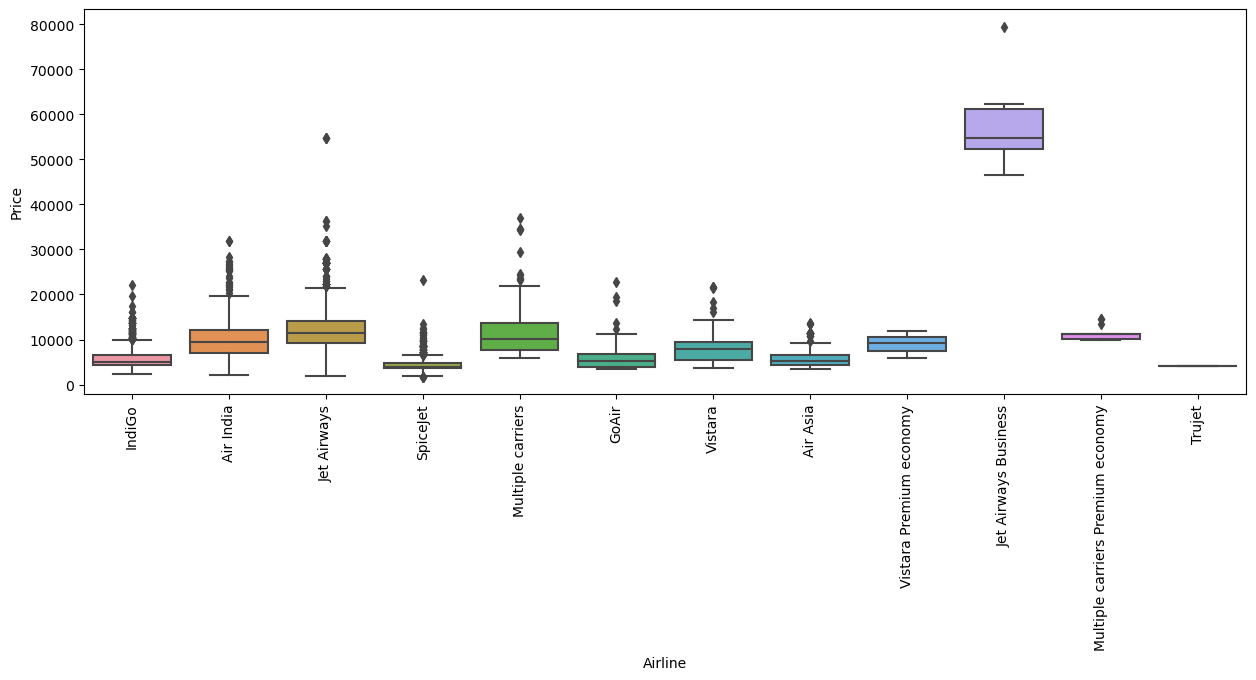

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(y='Price',x='Airline',data=df)
plt.xticks(rotation='vertical')
plt.show()

**Conclusion** From the graph we can see that Jet Airways Business has the highest Price. Apart from the first Airline, almost all are having a similar median

# Feature Encoding

In [34]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Duration_total_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45,285


In [35]:
np.round(df['Additional_Info'].value_counts()/len(df)*100,2)

No info                         78.11
In-flight meal not included     18.55
No check-in baggage included     3.00
1 Long layover                   0.18
Change airports                  0.07
Business class                   0.04
No Info                          0.03
1 Short layover                  0.01
Red-eye flight                   0.01
2 Long layover                   0.01
Name: Additional_Info, dtype: float64

We can observe that the column Additional info has no info ,for the majority of the values (78%) so we have to drop this column. Additionally, we don't need the column route as we have the source and destination columns. Finally the column duration total minutes isn't necessary because we capture this information with the columns duration_hours and duration minutes 

In [36]:
df.drop(columns=['Additional_Info','Route','Duration_total_mins'],axis=1,inplace=True)

In [37]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1 stop,13302,3,1,16,50,21,35,4,45


In [38]:
#seperate the columns at numerical and categorical
cat_col=[col for col in df.columns if df[col].dtype=='object']
num_col=[col for col in df.columns if df[col].dtype!='object']

in this dataset, we have many sub-categories, which creates the curse of dimensionality in ML
so let's use Target Guided Mean Encoding to get rid of this

One-Hot encoding the column source

In [39]:
df['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [40]:
for category in df['Source'].unique():
    df['Source_'+category]=df['Source'].apply(lambda x: 1 if x==category else 0)

In [41]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,Air India,Kolkata,Banglore,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,Jet Airways,Delhi,Cochin,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,IndiGo,Banglore,New Delhi,1 stop,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


In [42]:
df.drop(columns=['Source'],axis=1,inplace=True)

in the columns airlines, destination and stops we have many sub-categories, which creates the curse of dimensionality in ML
so let's use Target Guided Mean Encoding to get rid of this

In [43]:
airlines=df.groupby(['Airline'])['Price'].mean().sort_values().index
airlines

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [44]:
dict1={key:index for index,key in enumerate(airlines,0)}
df['Airline']=df['Airline'].map(dict1)
df.head()

,Airline,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,Banglore,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,Cochin,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,Banglore,1 stop,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,New Delhi,1 stop,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


In [45]:
#encoding the column destination
dest=df.groupby(['Destination'])['Price'].mean().sort_values().index
dict2={key:index for index,key in enumerate(dest,0)}
df['Destination']=df['Destination'].map(dict2)

In [46]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [47]:
stops={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
df['Total_Stops']=df['Total_Stops'].map(stops)

In [48]:
df.head()

,Airline,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,5,0,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,3,2,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,4,2,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,3,1,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,5,1,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


# Handling Outliers

In [49]:
df.describe()

,Airline,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,6.674967,3.243213,0.824190,9087.214567,12.682925,5.534731,12.491013,24.409287,13.349186,24.690601,10.244898,28.326624,0.205673,0.268770,0.424640,0.035667,0.065250
std,3.192209,1.189558,0.675229,4611.548810,8.803800,2.987626,5.748820,18.767801,6.859317,16.506808,8.494916,16.945817,0.404212,0.443341,0.494311,0.185468,0.246978
min,0.000000,0.000000,0.000000,1759.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000,5277.000000,5.000000,3.000000,8.000000,5.000000,8.000000,10.000000,2.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.000000,1.000000,8372.000000,6.000000,5.000000,11.000000,25.000000,14.000000,25.000000,8.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,4.000000,1.000000,12373.000000,21.000000,6.000000,18.000000,40.000000,19.000000,35.000000,15.000000,45.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,11.000000,5.000000,4.000000,79512.000000,27.000000,12.000000,23.000000,55.000000,23.000000,55.000000,47.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Price', ylabel='Density'>

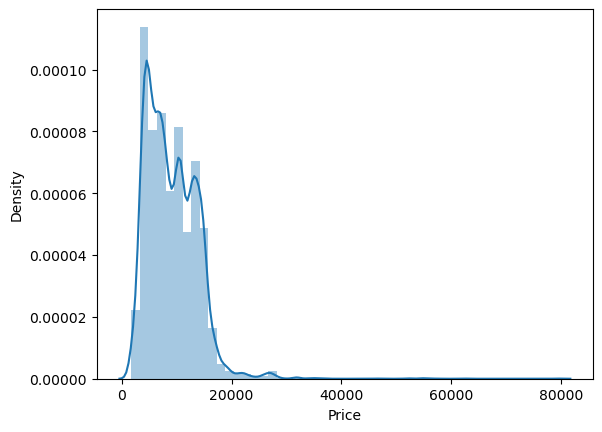

In [50]:
sns.distplot(df['Price'])

To deal with these outliers I will use a 3 std deviation approach to remove outliers in this case

In [51]:
df=df[np.abs(df['Price']-df['Price'].mean())<=(3*df['Price'].std())]

<AxesSubplot:xlabel='Price', ylabel='Density'>

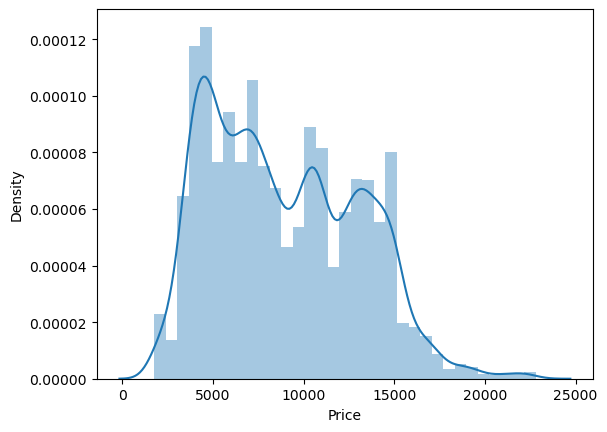

In [52]:
sns.distplot(df['Price'])

# Feature Selection

Finding out the best feature which will contribute most to the target variable. 
For this project, I will use mutual_info_regression. Its Backbone is Various statistical tests like Chi-sq, Anova & p-value.

In [53]:
X=df.drop(['Price'],axis=1)
y=df['Price']

In [54]:
X.dtypes

Airline                int64
Destination            int64
Total_Stops            int64
journey_day            int64
journey_month          int64
Dep_Time_hour          int64
Dep_Time_minute        int64
Arrival_Time_hour      int64
Arrival_Time_minute    int64
Duration_hours         int64
Duration_mins          int64
Source_Banglore        int64
Source_Kolkata         int64
Source_Delhi           int64
Source_Chennai         int64
Source_Mumbai          int64
dtype: object

In [55]:
mutual_info_regression(X,y)

array([0.97609351, 1.10674615, 0.79350775, 0.18744157, 0.23055648,
       0.34639391, 0.25837853, 0.41239315, 0.35157477, 0.46515723,
       0.34821263, 0.37900623, 0.45985028, 0.52555065, 0.13074122,
       0.20415123])

In [56]:
imp=pd.DataFrame(mutual_info_regression(X,y),index=X.columns)
imp.columns=['importance']

In [57]:
imp.sort_values(by='importance',ascending=False)

,importance
Destination,1.111845
Airline,0.979736
Total_Stops,0.787483
Source_Delhi,0.526336
Duration_hours,0.468631
Source_Kolkata,0.462157
Arrival_Time_hour,0.397946
Source_Banglore,0.385157
Arrival_Time_minute,0.349299
Dep_Time_hour,0.346371


Using mutual info regression we want only the values which have importance greater than 0 and less than 2. In this case, we keep all the features

# Modeling

In [62]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
#scale the data using standarscaler
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

In [89]:
#leanear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
#cross validation
scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=10)
print('R2 Score:',r2_score(y_test, y_pred))
print('Mean R2 Score :',scores.mean())


R2 Score: 0.6319802216036567
Mean R2 Score : 0.629266519692013


In [92]:
#Decision Tree Regression

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)
y_pred = tree_reg.predict(X_test)
#cross validation
scores = cross_val_score(tree_reg, X_train, y_train, scoring='r2', cv=10)
print('R2 Score:',r2_score(y_test, y_pred))
print('Mean R2 Score :',scores.mean())

R2 Score: 0.7119324634552924
Mean R2 Score : 0.7167900464828538


In [102]:
#Support Vector Regression

svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train,y_train)
y_pred = svm_reg.predict(X_test)
#cross validation
scores = cross_val_score(svm_reg, X_train, y_train, scoring='r2', cv=10)
print('R2 Score:',r2_score(y_test, y_pred))
print('Mean R2 Score :',scores.mean())

R2 Score: 0.5731542061642212
Mean R2 Score : 0.5696779310791328


In [100]:
#Random Forest Regression

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_test)
#cross validation
scores = cross_val_score(rf_reg, X_train, y_train, scoring='r2', cv=10)
print('R2 Score:',r2_score(y_test, y_pred))
print('Mean R2 Score :',scores.mean())

R2 Score: 0.8143278758365561
Mean R2 Score : 0.8159708651950588


The best model is the Random Forest Regression with r2 score : 0.81. Now lets try to find the best parameters for this model!

# Hyperparameter tuning

In [106]:
#searching the best parameters for the model
param_grid = [{'bootstrap':[False,True],'n_estimators': [50, 100, 200, 250, 300],'max_depth': [None, 100, 200, 300, 400]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False, True],
                          'max_depth': [None, 100, 200, 300, 400],
                          'n_estimators': [50, 100, 200, 250, 300]}],
             return_train_score=True, scoring='r2')

In [107]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': None, 'n_estimators': 250}

In [109]:
#Random Forest Regression using best parameters

rf_reg = RandomForestRegressor(bootstrap= True, max_depth= None, n_estimators= 250)
rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_test)
#cross validation
scores = cross_val_score(rf_reg, X_train, y_train, scoring='r2', cv=10)

print('R2 Score:',r2_score(y_test, y_pred))
print('Mean R2 Score :',scores.mean())

R2 Score: 0.8151477311507681
Mean R2 Score : 0.8178145010142895
